In [61]:
from data import InkmlDataset_PL
from models.lstm_ctc import LSTM_TemporalClassification_PL
from torchaudio.models.decoder import ctc_decoder
import matplotlib.pyplot as plt
import numpy as np
from data import *

model = LSTM_TemporalClassification_PL().load_from_checkpoint("logs/lstm_ctc/version_1/checkpoints/epoch=22-step=20470.ckpt")
dm = InkmlDataset_PL(root_dir="dataset/crohme2019")
dm.setup()
# Set the model to evaluation mode
model.eval()


LSTM_TemporalClassification_PL(
  (model): LSTM_TemporalClassification(
    (lstm): LSTM(3, 256, num_layers=2, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=512, out_features=109, bias=True)
    (log_softmax): LogSoftmax(dim=2)
  )
  (criterion): CTCLoss()
)

In [62]:
tokens = list(model.vocab.keys())
beam_search = ctc_decoder(
    lexicon=None,
    tokens=tokens,
    nbest=1,
    blank_token='',
    
)

In [79]:
# x, y, lenx, leny = dm.test_dataset.__getitem__(0)
path = 'dataset/crohme2019/crohme2019/valid/20_em_37.inkml'
ink = Inkml(path)

traces = ink.getTraces()
combined_traces = np.vstack([np.array(trace)[:, :2] for trace in traces])
delta_traces = np.diff(combined_traces, axis=0)
zeros_filter = np.all(delta_traces == 0, axis=1)
delta_traces = delta_traces[~zeros_filter]
delta_traces = delta_traces / np.sqrt((np.square(delta_traces[:, 0]) + np.square(delta_traces[:, 1])))[:, np.newaxis]  # delta x, delta y --> delta x/sqrt(delta x^2 + delta y^2), delta y/sqrt(delta x^2 + delta y^2

pen_up = [np.array([0] * len(trace)) for trace in traces]
for _, arr in enumerate(pen_up):
    arr[0] = 1

combined_pen_up = np.concatenate(pen_up)[1:, np.newaxis][~zeros_filter]
combined_traces = np.hstack([delta_traces, combined_pen_up])
delta_traces_tensor = torch.tensor(combined_traces, dtype=torch.float32)

# item = dm.train_dataset.__getitem__(6)

output = model(delta_traces_tensor.unsqueeze(0).cuda())
output

tensor([[[-1.5033e+01, -1.1522e+01, -2.3110e+01,  ..., -1.3642e+01,
          -1.8725e+01, -1.9371e+01],
         [-1.3232e-05, -2.5300e+01, -3.1322e+01,  ..., -2.6525e+01,
          -3.6729e+01, -1.9148e+01],
         [ 0.0000e+00, -2.7001e+01, -3.0315e+01,  ..., -2.9304e+01,
          -3.4036e+01, -3.2203e+01],
         ...,
         [-2.3126e-05, -1.5770e+01, -2.3184e+01,  ..., -2.3086e+01,
          -2.6213e+01, -2.3632e+01],
         [-3.0811e-04, -1.3609e+01, -2.1048e+01,  ..., -1.9729e+01,
          -2.1910e+01, -2.2553e+01],
         [-7.1526e-07, -1.7247e+01, -2.4841e+01,  ..., -2.1787e+01,
          -2.5513e+01, -2.7568e+01]]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

3 Right \times Right 3 Sup 2 NoRel - Below 2 NoRel + Right 5 Right \times Right t Right 5 Right ) Sup 2 NoRel - Below 2 NoRel = Right 3 Right \times Right u 1 NoRel 2 NoRel - Below 2 NoRel + Right 5 Right \times Right 0 Sub 2 NoRel 2 NoRel - Below 2 

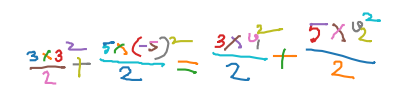

In [80]:
normal_prob = np.exp(output.squeeze(0).cpu().detach().numpy())

argmax = np.argmax(normal_prob, axis=1)
argmax = [tokens[i] for i in argmax if i != 0]
for i in argmax:
    print(i, end=" ")

# print([np.array(trace)[:, :2].shape for trace in ink.getTraces()])

plt.figure(figsize=(5,1))
plt.rcParams['axes.facecolor'] = 'black'  # Set background color to black
plt.axis('off')
for trace in ink.getTraces():
    trace_arr = np.array(trace)
    plt.plot(trace_arr[:, 0], - trace_arr[:, 1]) # invert y coordinate

In [73]:
beam_search_output = beam_search(output.cpu())
print(beam_search_output, end="\n\n")

output_str = ""
for i in [tokens[i] for i in beam_search_output[0][0].tokens.numpy() if i != 0]:
    output_str += i + " "

print(output_str.replace("|", " ").strip())


[[CTCHypothesis(tokens=tensor([101,  26, 108,  26,  45,  26,  45,  74,  32,  39,  32,  39,  45,  39,
         45,  74,  32,  95, 108,  95,  45,  95,  45,   1,  32,  26,  32,   1,
         32,  39,  32,   1,  32,  95, 101]), words=[], score=-1.6713729408642592, timesteps=tensor([  0,   1,  75,  76, 134, 135, 193, 194, 223, 224, 290, 291, 346, 347,
        400, 401, 428, 429, 489, 490, 542, 543, 590, 591, 605, 606, 660, 661,
        673, 674, 742, 743, 753, 754, 816], dtype=torch.int32))]]

x Sub x NoRel x NoRel + Right y Right y NoRel y NoRel + Right z Sub z NoRel z NoRel - Right x Right - Right y Right - Right z
